Here we demonstrate how to use the computational microscope model for image generation and adaptive optics scenarios

In [1]:
import numpy as np
import tensorflow as tf
from diffao.czt_tf import czt_factors, czt2d

from diffao.microscope_model import *
from diffao.wavefronts import Zernike

import matplotlib.pyplot as plt

%matplotlib inline

2023-06-22 01:02:25.077504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 01:02:25.620539: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-22 01:02:25.620600: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-22 01:02:25.620606: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [2]:
RES = 512 # simulation resolution

## PSF engineering

Here we load a target PSF image:

In [3]:
import cv2

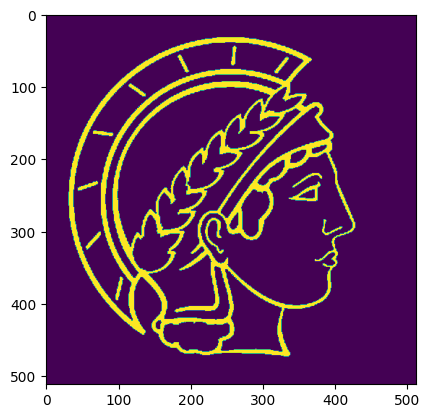

In [6]:
psf_target = cv2.imread('./minerva.png')
psf_target = cv2.resize(psf_target, [RES, RES], interpolation = cv2.INTER_CUBIC) # Resize to simulation resolution
psf_target = np.asarray(psf_target<128, dtype=np.float32)[..., -1]
plt.imshow(psf_target)

In [8]:
# Initialize microscope model with some parameters imaging 0.5 um beads:
mm = MicroscopeModel(zoom_level=10,
                     simulation_resolution=RES,
                     z_planes=[0.0*UM], # We use this parameter to specify which planes (offsets) are simulated. 0.0 - focal plane. 
                     pmt_simulation=MicroscopeModel.PMT_NONE,
                     pmt_gain=100.0,
                     pmt_bgr_noise_lvl=0.005,
                     crop_output=False)
mm.simulation.summary()
mm.bead_object_function(0.5*UM)

Microscope model is initialized with FOV of 20.0um at 512px resolution.
Initialized Debye model with NA=0.9475,
Angular aperture alpha=1.5858
Instantitaing CZT with float32 (complex64) floating point precision.
Using L=1024. You may suggest a better value for performance.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512)]        0         
                                                                 
 circular_beam_1 (CircularBe  (None, 512, 512, 2)      0         
 am)                                                             
                                                                 
 microscope_objective_1 (Mic  (None, 1, 512, 512)      786433    
 roscopeObjective)                                               
                                                                 
Total params: 786,433
Trainable params: 786,433
No

In [9]:
tf_holo_phase = tf.Variable(np.zeros([1, RES, RES]), trainable=True) # This is input phase modulation that will be subject to optimization
tf_holo_target = tf.Variable(psf_target)

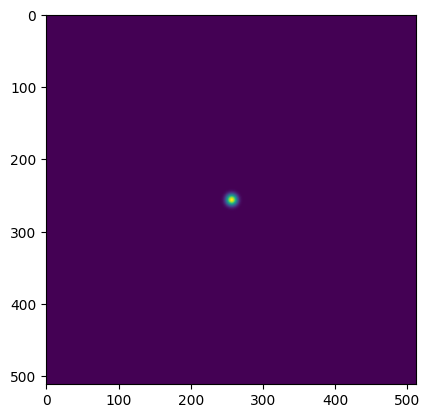

In [11]:
f = mm.simulation(tf.exp(tf.complex(tf.zeros_like(tf_holo_phase), tf_holo_phase*2.5)))
plt.imshow(f[0,0])

In [12]:
@tf.function
def cor_tf(a, b):
    """ Image corellation coefficient, used for loss
    """
    n = np.product(a.shape)
    mean_a = tf.reduce_mean(a)
    mean_b = tf.reduce_mean(b)
    std_a = tf.sqrt(tf.reduce_sum(tf.square(a-mean_a))/(n-1))
    std_b = tf.sqrt(tf.reduce_sum(tf.square(b-mean_b))/(n-1))
    return tf.reduce_sum((a - mean_a)*(b-mean_b))/(n-1)/std_a/std_b

cor = tf.Variable(0.0, dtype=tf.float32) # Variable for intemiediate result storing and optimization monitoring
L1 = tf.keras.regularizers.L1(1.0/RES**2)

def makeloss():
    """Make sure dimensions of arguments of cov_tf match! Otherwise weird things happen as it still would compute!
    """
    #@tf.function
    def loss():
        sim = mm.simulation(tf.exp(tf.complex(tf.zeros_like(tf_holo_phase), tf_holo_phase)))
        # NOTE: simulation returns result in format [MODULATION_NR (batch), PLANE, Y, X]
        # Here we fit the single plane, so we index [0, 0, :, :] for the only moudulation and the only plane,
        # So we expand the dimensions of holo_target by indexing it with [None, None]
        # Making its shape [1, 1, RES, RES]:
        cor_ = cor_tf(sim, tf_holo_target[None, None])
        cor.assign(cor_)
        return -cor_-mm.mo.total_intensity # Total intensity component can be omitted for faster convergence.
                                           # Probably some regularizers on the phase could help, to be explored.
    return loss
    
loss = makeloss()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

In [14]:
# Trainable parameters, here we optimize input modulation phase
trainable = [tf_holo_phase]

for _ in range(400):
    with tf.GradientTape() as tape:
        l = loss()
        gradients = tape.gradient(l, trainable)
        optimizer.apply_gradients(zip(gradients, trainable))

    print(_, f'cor: {cor.numpy()}, loss: {l.numpy()}', end='\r')

(<AxesSubplot: title={'center': 'Simulated PSF'}>,
 Text(0.5, 1.0, 'Simulated PSF'))

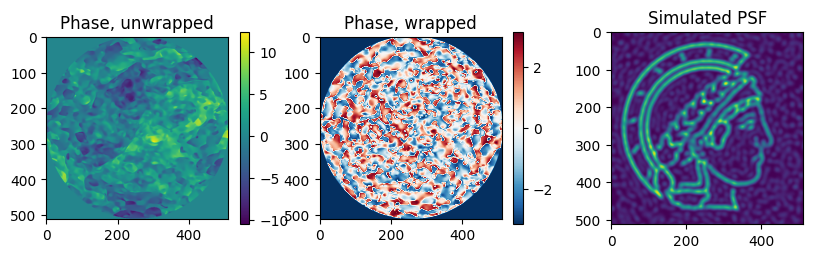

In [15]:
f = mm.simulation(tf.exp(tf.complex(tf.zeros_like(tf_holo_phase), tf_holo_phase)))
plt.figure(figsize=(10,2.5))
plt.subplot(131), plt.imshow(tf_holo_phase.numpy()[0]), plt.colorbar(), plt.title('Phase, unwrapped')
plt.subplot(132), plt.imshow(tf_holo_phase.numpy()[0]%6.28-3.14, cmap='RdBu_r'), plt.colorbar(), plt.title('Phase, wrapped')
plt.subplot(133), plt.imshow(f[0,0]), plt.title('Simulated PSF')

In [16]:
holo_minerva = tf_holo_phase.numpy()
np.save('minerva.npy', holo_minerva)

## Same idea, but for volumetric hologram

We simulate several planes close to focal and constrain each to contain a particular light distribution, for example frames of dancing stick figure animation:

Text(0.5, 1.0, 'Loaded frames')

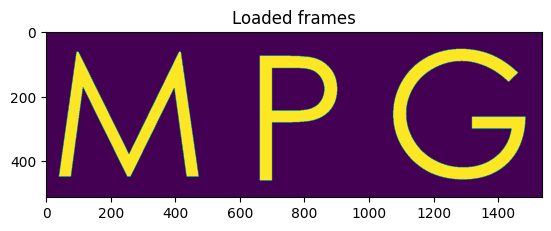

In [5]:
# Volumetric hologram
psf_target = cv2.imread('./mpg.png')
psf_target = cv2.resize(psf_target, [RES, RES], interpolation = cv2.INTER_CUBIC)
psf_target = np.transpose(np.asarray(psf_target<128, dtype=np.float32), [2, 0, 1])[::-1]

plt.imshow(np.hstack(psf_target[..., :]))
plt.title('Loaded frames')

In [8]:
# Initialize microscope model to simulate 3 planes (z_planes parameter):
# z_planes=[-3.0*UM, 0.0, +3*UM]
mm = MicroscopeModel(zoom_level=10,
                     simulation_resolution=RES,
                     z_planes=[-3.0*UM, 0.0, +3*UM], # We use this parameter to specify which planes (offsets) are simulated. 0.0 - focal plane. 
                     pmt_simulation=MicroscopeModel.PMT_NONE,
                     pmt_gain=100.0,
                     pmt_bgr_noise_lvl=0.005,
                     crop_output=False)
mm.simulation.summary()
mm.bead_object_function(0.5*UM)

Microscope model is initialized with FOV of 20.0um at 512px resolution.
Initialized Debye model with NA=0.9475,
Angular aperture alpha=1.5858
Instantitaing CZT with float32 (complex64) floating point precision.
Using L=1024. You may suggest a better value for performance.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512)]        0         
                                                                 
 circular_beam_1 (CircularBe  (None, 512, 512, 2)      0         
 am)                                                             
                                                                 
 microscope_objective_1 (Mic  (None, 3, 512, 512)      786433    
 roscopeObjective)                                               
                                                                 
Total params: 786,433
Trainable params: 786,433
No

In [9]:
# Initialize variables for optimization
tf_holo_phase = tf.Variable(np.zeros([1, RES, RES]), trainable=True) # This is input phase modulation that will be subject to optimization
tf_holo_target = tf.Variable(psf_target)
print(tf_holo_target.shape)

(3, 512, 512)


In [10]:
@tf.function
def cor_tf(a, b):
    """ Image corellation coefficient, used for loss
    """
    n = np.product(a.shape)
    mean_a = tf.reduce_mean(a)
    mean_b = tf.reduce_mean(b)
    std_a = tf.sqrt(tf.reduce_sum(tf.square(a-mean_a))/(n-1))
    std_b = tf.sqrt(tf.reduce_sum(tf.square(b-mean_b))/(n-1))
    return tf.reduce_sum((a - mean_a)*(b-mean_b))/(n-1)/std_a/std_b

cor = tf.Variable(0.0, dtype=tf.float32) # Variable for intemiediate result storing and optimization monitoring
L1 = tf.keras.regularizers.L1(1.0/RES**2)

def makeloss():
    """Make sure dimensions of arguments of cov_tf match! Otherwise weird things happen as it still would compute!
    """
    #@tf.function
    def loss():
        sim = mm.simulation(tf.exp(tf.complex(tf.zeros_like(tf_holo_phase), tf_holo_phase)))
        # NOTE: simulation returns result in format [MODULATION_NR (batch), PLANE, Y, X]
        # Here we fit the single plane, so we index [0, 0, :, :] for the only moudulation and the only plane,
        # So we expand the dimensions of holo_target by indexing it with [None, None]
        # Making its shape [1, 3, RES, RES]
        # As we have 3 planes in our simulation
        cor_ = cor_tf(sim, tf_holo_target[None])
        cor.assign(cor_)
        return -cor_-mm.mo.total_intensity # Total intensity component can be omitted for faster convergence.
                                           # Probably some regularizers on the phase could help, to be explored.
    return loss
    
loss = makeloss()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

In [ ]:
# Trainable parameters, here we optimize input modulation phase
trainable = [tf_holo_phase]

for _ in range(300):
    with tf.GradientTape() as tape:
        l = loss()
        gradients = tape.gradient(l, trainable)
        optimizer.apply_gradients(zip(gradients, trainable))

    print(_, f'cor: {cor.numpy()}, loss: {l.numpy()}', end='\r')

In [12]:
holo_mpg = tf_holo_phase.numpy()
np.save('mpg.npy', holo_mpg)

2023-06-22 01:01:29.183931: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: map/while/body/_1/map/while/StatefulPartitionedCall/map/while/body/_174/map/while/StatefulPartitionedCall/rot90_1/Assert/AssertGuard/branch_executed/_373


Text(0.5, 1.0, 'PSF at differernt planes')

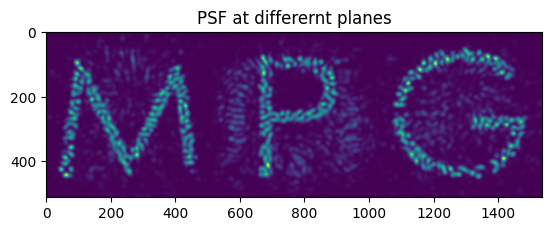

In [13]:
vol = mm.simulation(tf.exp(tf.complex(tf.zeros_like(holo_mpg), holo_mpg)))
plt.imshow(np.hstack(vol[0]))
plt.title('PSF at differernt planes')

## Test holograms

by simulating larger volume

In [4]:
holo_mpg = np.load('mpg.npy')
holo_minerva = np.load('minerva.npy')

In [5]:
test_z_planes = np.linspace(-5.0*UM, 5.0*UM, 21)
test_z_planes

array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
        0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ])

In [7]:
# Initialize microscope model to simulate 3 planes (z_planes parameter):
mm = MicroscopeModel(zoom_level=8, #Just out of curiosity tried different zoom level here
                     simulation_resolution=RES,
                     z_planes=test_z_planes, # We use this parameter to specify which planes (offsets) are simulated. 0.0 - focal plane. 
                     pmt_simulation=MicroscopeModel.PMT_NONE,
                     pmt_gain=100.0,
                     pmt_bgr_noise_lvl=0.005,
                     crop_output=False)
mm.simulation.summary()
mm.bead_object_function(0.5*UM)

Microscope model is initialized with FOV of 25.0um at 512px resolution.
Initialized Debye model with NA=0.9475,
Angular aperture alpha=1.5858
Instantitaing CZT with float32 (complex64) floating point precision.
Using L=1024. You may suggest a better value for performance.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512)]        0         
                                                                 
 circular_beam_1 (CircularBe  (None, 512, 512, 2)      0         
 am)                                                             
                                                                 
 microscope_objective_1 (Mic  (None, 21, 512, 512)     786433    
 roscopeObjective)                                               
                                                                 
Total params: 786,433
Trainable params: 786,433
No

(<matplotlib.image.AxesImage at 0x7f29402fcd00>, Text(0.5, 1.0, 'focal plane'))

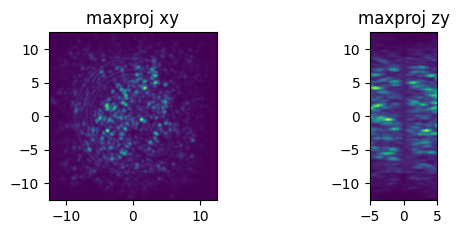

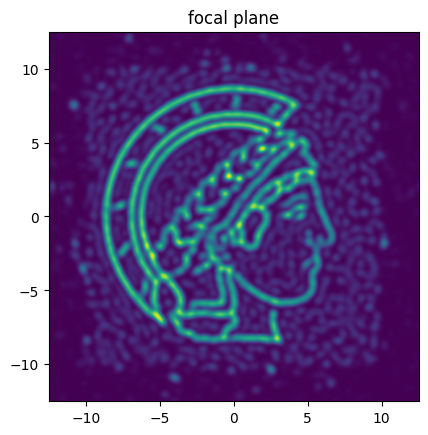

In [23]:
# Plot volume with Minerva

vol = mm.simulation(tf.exp(tf.complex(tf.zeros_like(holo_minerva), holo_minerva)))
FOV = mm.fov_size
fig = plt.figure()

ax0 = fig.add_subplot(2,2,1)
plt.sca(ax0), plt.imshow(np.max(vol[0], axis=0), extent=[-FOV/2, FOV/2,-FOV/2, FOV/2]), plt.title('maxproj xy')
ax1 = fig.add_subplot(2,2,2, sharey = ax0)
plt.sca(ax1), plt.imshow(np.max(vol[0], axis=2).T, extent=[-5, 5, -FOV/2, FOV/2]), plt.title('maxproj zy')

plt.figure()
plt.imshow(vol[0, 10], extent=[-FOV/2, FOV/2, -FOV/2, FOV/2]), plt.title('focal plane')


(<matplotlib.image.AxesImage at 0x7f2940222d00>, Text(0.5, 1.0, 'focal plane'))

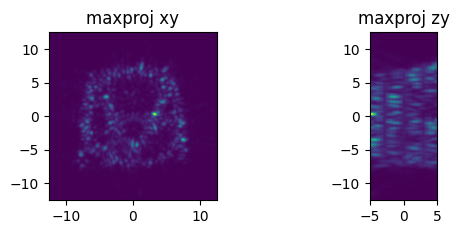

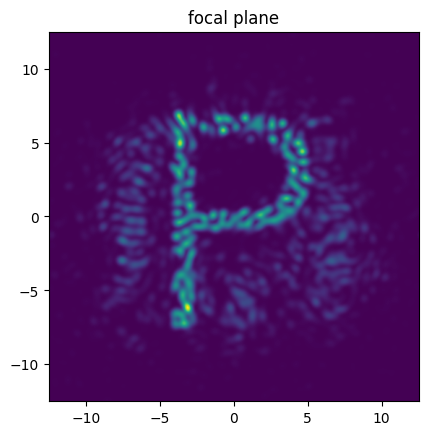

In [24]:
# Plot volume with MPG

vol = mm.simulation(tf.exp(tf.complex(tf.zeros_like(holo_mpg), holo_mpg)))
FOV = mm.fov_size
fig = plt.figure()

ax0 = fig.add_subplot(2,2,1)
plt.sca(ax0), plt.imshow(np.max(vol[0], axis=0), extent=[-FOV/2, FOV/2,-FOV/2, FOV/2]), plt.title('maxproj xy')
ax1 = fig.add_subplot(2,2,2, sharey = ax0)
plt.sca(ax1), plt.imshow(np.max(vol[0], axis=2).T, extent=[-5, 5, -FOV/2, FOV/2]), plt.title('maxproj zy')

plt.figure()
plt.imshow(vol[0, 10], extent=[-FOV/2, FOV/2, -FOV/2, FOV/2]), plt.title('focal plane')
